In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 1*28*28 
num_classes = 10
num_epochs = 10
batch_size = 25
learning_rate = 0.001

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data', 
                                          train=False, 
                                          transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = (0,1,2,3,4,5,6,7,8,9)

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> [n, 1, 28, 28]
        x = self.pool(F.relu(self.conv1(x)))  # -> [n, 6, 12, 12]
        x = self.pool(F.relu(self.conv2(x)))  # -> [n, 16, 4, 4]
        x = x.view(-1, 16 * 4 * 4)            # -> [n, 256]
        x = F.relu(self.fc1(x))               # -> [n, 120]
        x = F.relu(self.fc2(x))               # -> [n, 84]
        x = self.fc3(x)                       # -> [n, 10]
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [4]:
# Training the model

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # origin shape: [25, 1, 28, 28] = 25, 1, 784
        # input_layer: 1 input channel, 6 output channels, 5 kernel size
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [1200/2400], Loss: 2.3132
Epoch [1/10], Step [2400/2400], Loss: 2.2888
Epoch [2/10], Step [1200/2400], Loss: 2.2910
Epoch [2/10], Step [2400/2400], Loss: 2.2776
Epoch [3/10], Step [1200/2400], Loss: 2.2322
Epoch [3/10], Step [2400/2400], Loss: 2.2192
Epoch [4/10], Step [1200/2400], Loss: 1.9089
Epoch [4/10], Step [2400/2400], Loss: 0.9831
Epoch [5/10], Step [1200/2400], Loss: 0.4448
Epoch [5/10], Step [2400/2400], Loss: 0.3116
Epoch [6/10], Step [1200/2400], Loss: 0.1483
Epoch [6/10], Step [2400/2400], Loss: 0.0708
Epoch [7/10], Step [1200/2400], Loss: 0.2083
Epoch [7/10], Step [2400/2400], Loss: 0.2320
Epoch [8/10], Step [1200/2400], Loss: 0.2439
Epoch [8/10], Step [2400/2400], Loss: 0.2267
Epoch [9/10], Step [1200/2400], Loss: 0.1478
Epoch [9/10], Step [2400/2400], Loss: 0.1268
Epoch [10/10], Step [1200/2400], Loss: 0.0850
Epoch [10/10], Step [2400/2400], Loss: 0.1654
Finished Training


In [5]:
# Testing the model

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)    # max returns (value ,index)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print('Number of test samples: ',n_samples)
    print('Number of correct predictions: ', n_correct)
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')        

Number of test samples:  10000
Number of correct predictions:  9574
Accuracy of the network on the 10000 test images: 95.74 %
Accuracy of 0: 98.57142857142857 %
Accuracy of 1: 98.50220264317181 %
Accuracy of 2: 94.37984496124031 %
Accuracy of 3: 98.01980198019803 %
Accuracy of 4: 95.62118126272912 %
Accuracy of 5: 95.06726457399103 %
Accuracy of 6: 96.13778705636743 %
Accuracy of 7: 92.80155642023347 %
Accuracy of 8: 93.63449691991786 %
Accuracy of 9: 94.35084241823587 %


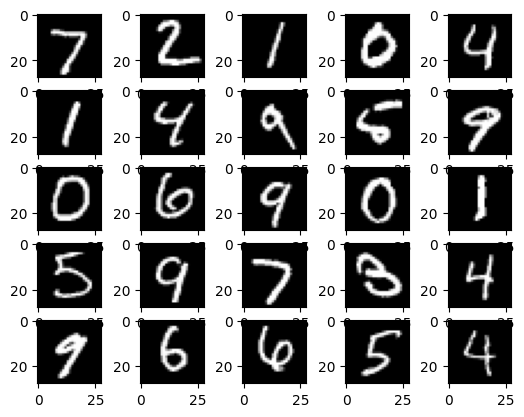

Predicted           Targets
7 2 1 0 4           7 2 1 0 4 
1 4 9 5 9           1 4 9 5 9 
0 6 9 0 1           0 6 9 0 1 
5 9 7 3 4           5 9 7 3 4 
9 6 6 5 4           9 6 6 5 4 


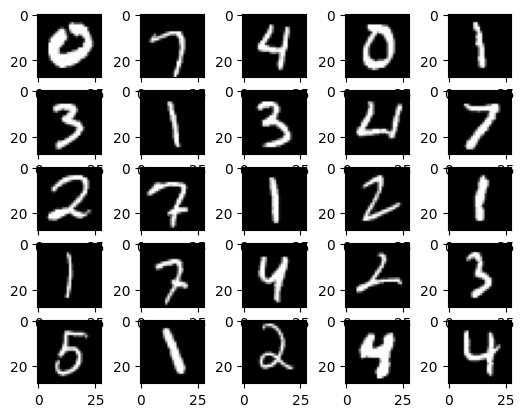

Predicted           Targets
0 7 4 0 1           0 7 4 0 1 
3 1 3 6 7           3 1 3 4 7 
2 7 1 2 1           2 7 1 2 1 
1 7 4 2 3           1 7 4 2 3 
5 1 2 4 4           5 1 2 4 4 


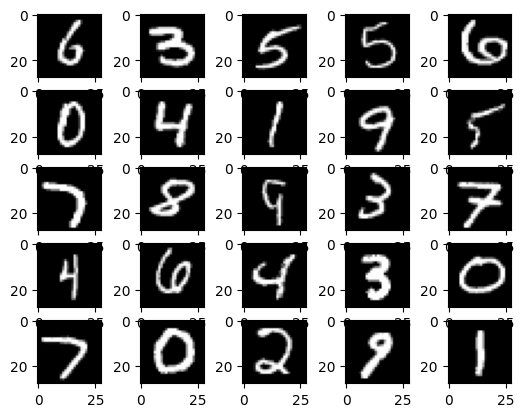

Predicted           Targets
6 3 5 5 6           6 3 5 5 6 
0 4 1 9 5           0 4 1 9 5 
7 8 9 3 7           7 8 9 3 7 
4 6 4 3 0           4 6 4 3 0 
7 0 2 9 1           7 0 2 9 1 


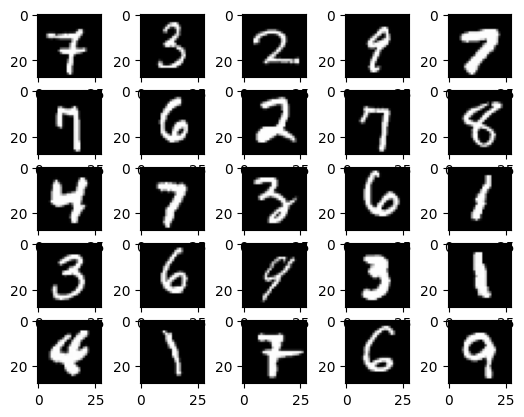

Predicted           Targets
7 3 2 9 7           7 3 2 9 7 
7 6 2 7 8           7 6 2 7 8 
4 7 3 6 1           4 7 3 6 1 
3 6 9 3 1           3 6 9 3 1 
4 1 7 6 9           4 1 7 6 9 


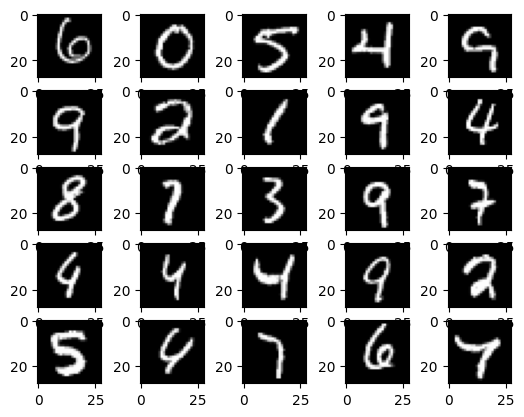

Predicted           Targets
6 0 5 4 9           6 0 5 4 9 
9 2 1 9 4           9 2 1 9 4 
8 7 3 9 7           8 7 3 9 7 
4 4 4 9 2           4 4 4 9 2 
5 4 7 6 7           5 4 7 6 7 


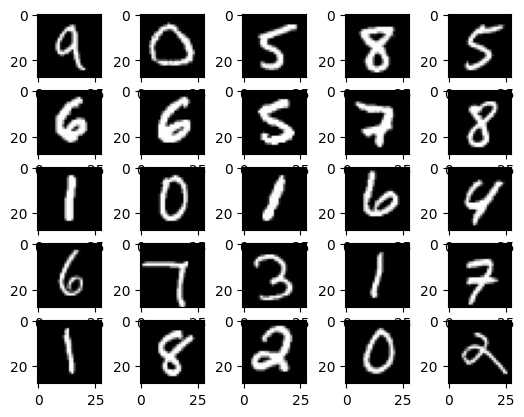

Predicted           Targets
9 0 5 8 5           9 0 5 8 5 
6 6 5 7 8           6 6 5 7 8 
1 0 1 6 4           1 0 1 6 4 
6 7 3 1 7           6 7 3 1 7 
1 8 2 0 3           1 8 2 0 2 


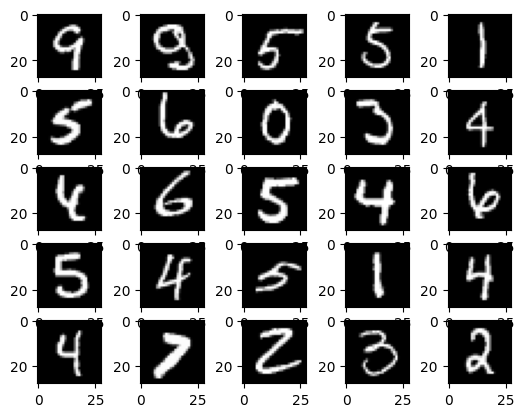

Predicted           Targets
9 9 5 5 1           9 9 5 5 1 
5 6 0 3 4           5 6 0 3 4 
4 6 5 4 6           4 6 5 4 6 
5 4 5 1 4           5 4 5 1 4 
4 7 2 3 2           4 7 2 3 2 


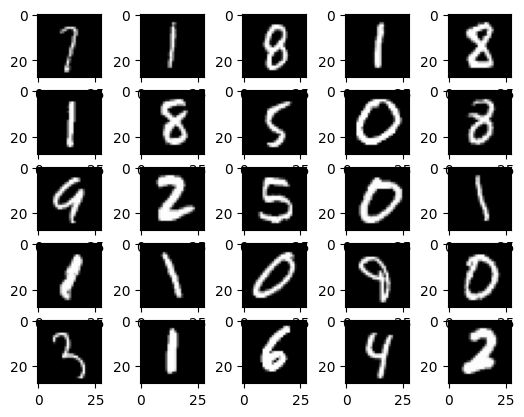

Predicted           Targets
7 1 8 1 8           7 1 8 1 8 
1 8 5 0 8           1 8 5 0 8 
9 2 5 0 1           9 2 5 0 1 
1 1 0 9 0           1 1 0 9 0 
3 1 6 4 2           3 1 6 4 2 


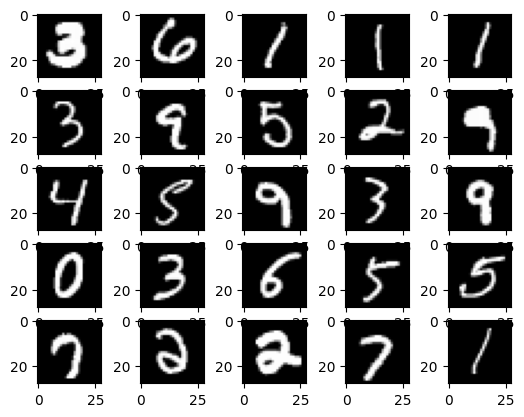

Predicted           Targets
3 6 1 1 1           3 6 1 1 1 
3 9 5 2 9           3 9 5 2 9 
4 5 9 3 9           4 5 9 3 9 
0 3 6 5 5           0 3 6 5 5 
7 3 2 7 1           7 2 2 7 1 


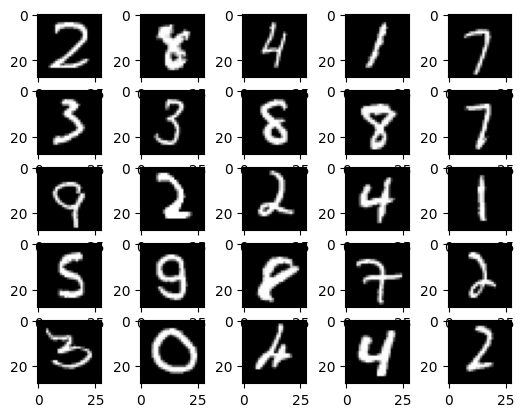

Predicted           Targets
2 8 4 1 7           2 8 4 1 7 
3 3 8 8 7           3 3 8 8 7 
9 2 2 4 1           9 2 2 4 1 
5 9 8 7 2           5 9 8 7 2 
3 0 4 4 2           3 0 4 4 2 


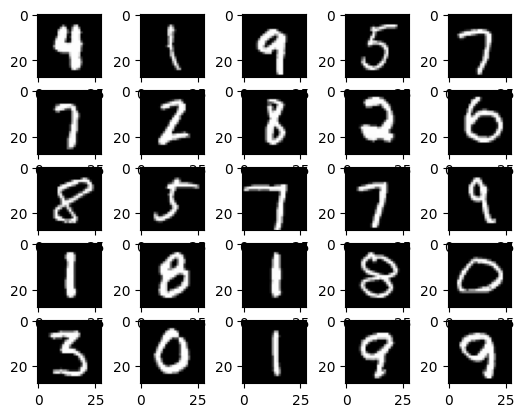

Predicted           Targets
4 1 9 5 7           4 1 9 5 7 
7 2 8 2 0           7 2 8 2 6 
8 5 7 7 9           8 5 7 7 9 
1 8 1 8 0           1 8 1 8 0 
3 0 1 9 9           3 0 1 9 9 


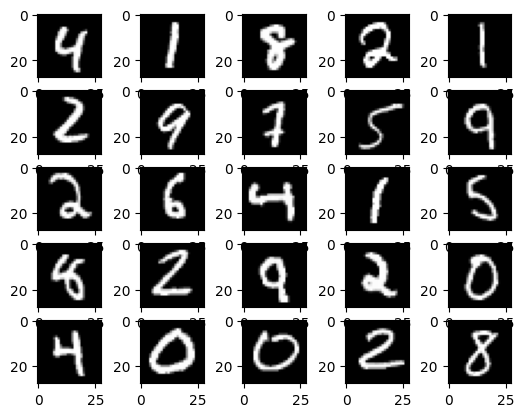

Predicted           Targets
4 1 8 2 1           4 1 8 2 1 
2 9 7 5 9           2 9 7 5 9 
2 6 4 1 5           2 6 4 1 5 
8 2 9 2 0           8 2 9 2 0 
4 0 0 2 8           4 0 0 2 8 


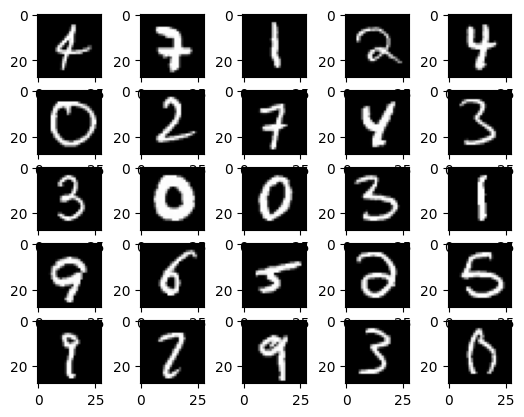

Predicted           Targets
4 7 1 2 4           4 7 1 2 4 
0 2 7 4 3           0 2 7 4 3 
3 0 0 5 1           3 0 0 3 1 
9 6 5 3 5           9 6 5 2 5 
7 7 9 3 0           9 2 9 3 0 


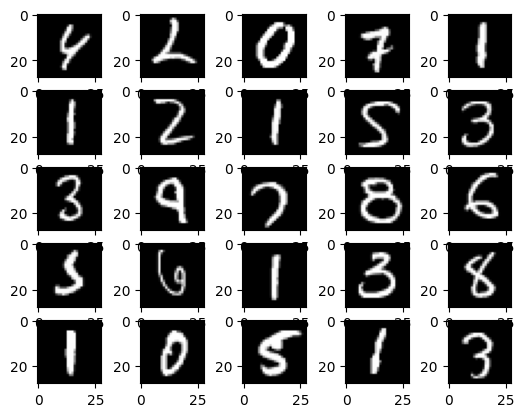

Predicted           Targets
4 2 0 7 1           4 2 0 7 1 
1 2 1 5 3           1 2 1 5 3 
3 9 7 8 6           3 9 7 8 6 
3 6 1 3 8           5 6 1 3 8 
1 0 5 1 3           1 0 5 1 3 


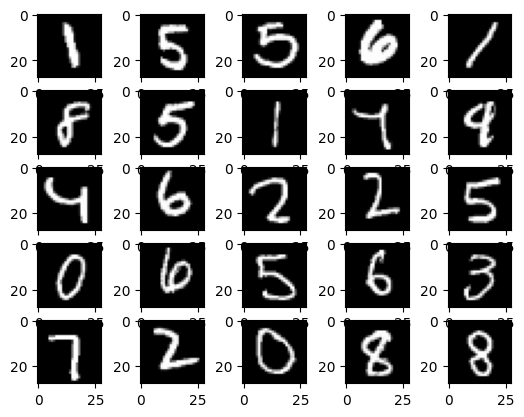

Predicted           Targets
1 5 5 6 1           1 5 5 6 1 
8 5 1 7 9           8 5 1 7 9 
4 6 2 2 5           4 6 2 2 5 
0 6 5 6 3           0 6 5 6 3 
7 2 0 8 8           7 2 0 8 8 


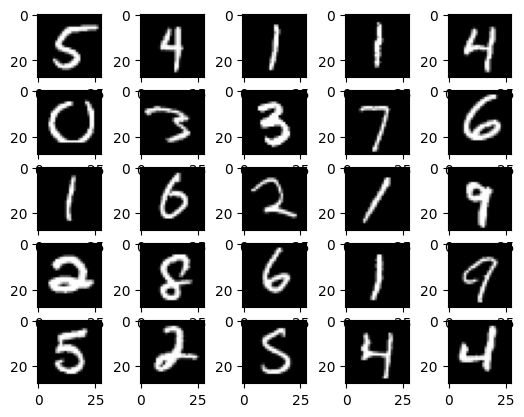

Predicted           Targets
5 4 1 1 4           5 4 1 1 4 
0 3 3 7 6           0 3 3 7 6 
1 6 2 1 9           1 6 2 1 9 
2 8 6 1 9           2 8 6 1 9 
5 2 5 4 4           5 2 5 4 4 


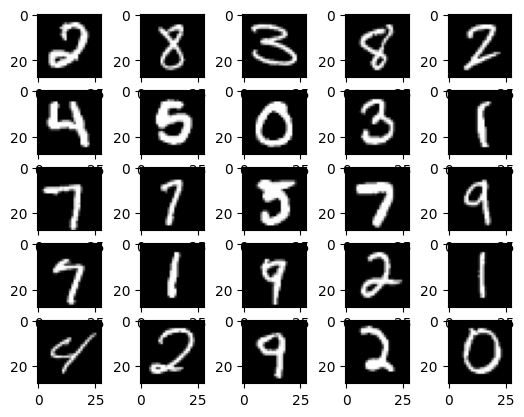

Predicted           Targets
2 8 3 9 2           2 8 3 8 2 
4 5 0 3 1           4 5 0 3 1 
7 7 3 7 9           7 7 5 7 9 
7 1 9 2 1           7 1 9 2 1 
9 2 9 2 0           4 2 9 2 0 


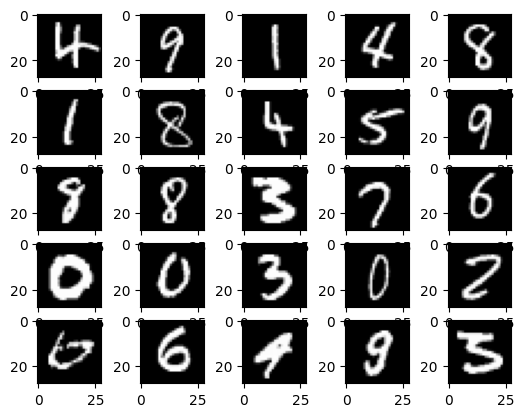

Predicted           Targets
4 9 1 4 8           4 9 1 4 8 
1 8 4 5 9           1 8 4 5 9 
7 8 3 7 6           8 8 3 7 6 
0 0 3 0 2           0 0 3 0 2 
0 6 4 8 5           6 6 4 9 3 


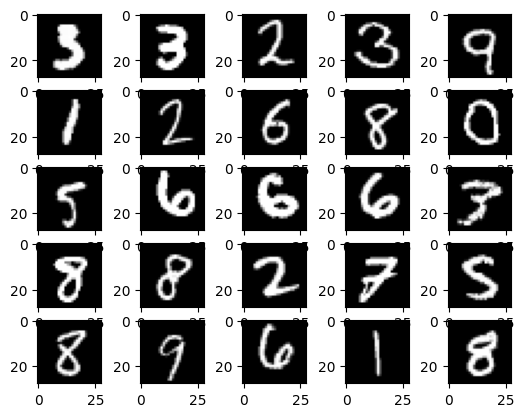

Predicted           Targets
3 3 2 3 9           3 3 2 3 9 
1 2 6 8 0           1 2 6 8 0 
5 6 6 6 3           5 6 6 6 3 
8 8 2 7 5           8 8 2 7 5 
8 9 6 1 8           8 9 6 1 8 


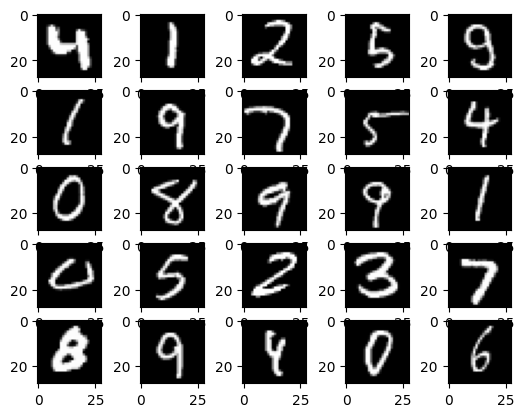

Predicted           Targets
4 1 2 5 9           4 1 2 5 9 
1 9 7 5 4           1 9 7 5 4 
0 8 9 9 1           0 8 9 9 1 
0 5 2 3 7           0 5 2 3 7 
8 9 4 0 6           8 9 4 0 6 


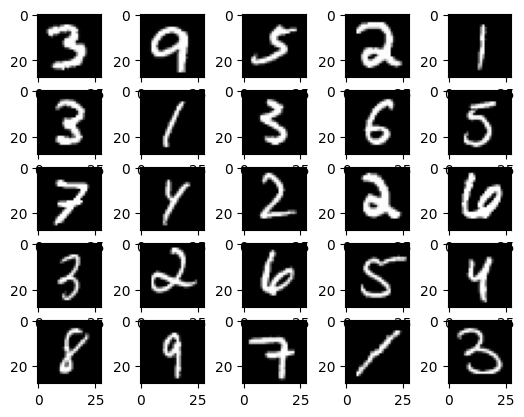

Predicted           Targets
3 9 5 2 1           3 9 5 2 1 
3 1 3 6 5           3 1 3 6 5 
7 1 2 2 6           7 4 2 2 6 
3 2 6 5 4           3 2 6 5 4 
8 9 7 1 3           8 9 7 1 3 


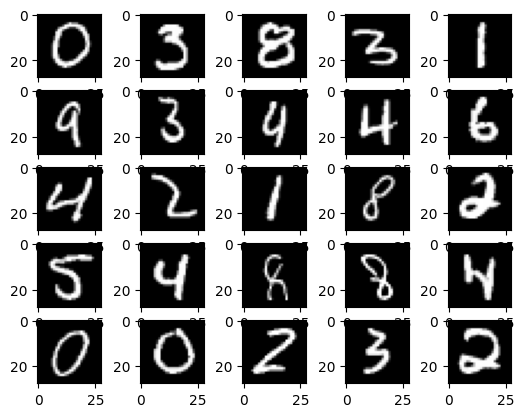

Predicted           Targets
0 3 8 3 1           0 3 8 3 1 
4 3 4 4 6           9 3 4 4 6 
4 2 1 8 2           4 2 1 8 2 
5 4 8 3 4           5 4 8 8 4 
0 0 2 3 2           0 0 2 3 2 


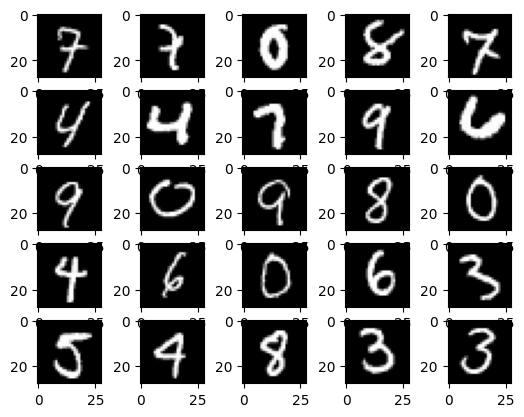

Predicted           Targets
9 9 0 8 7           7 7 0 8 7 
4 4 7 9 6           4 4 7 9 6 
9 0 9 8 0           9 0 9 8 0 
4 6 0 6 3           4 6 0 6 3 
5 9 8 3 3           5 4 8 3 3 


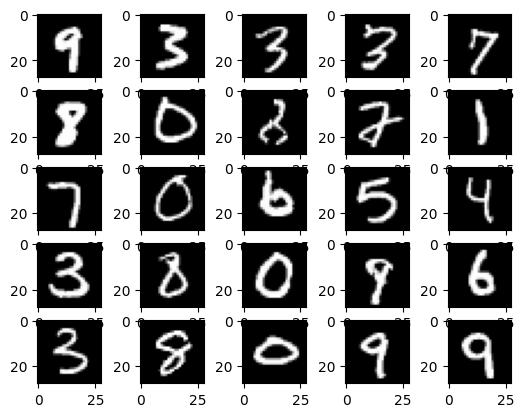

Predicted           Targets
9 3 3 3 7           9 3 3 3 7 
8 0 3 2 1           8 0 8 2 1 
7 0 6 5 4           7 0 6 5 4 
3 8 0 9 6           3 8 0 9 6 
3 8 0 9 9           3 8 0 9 9 


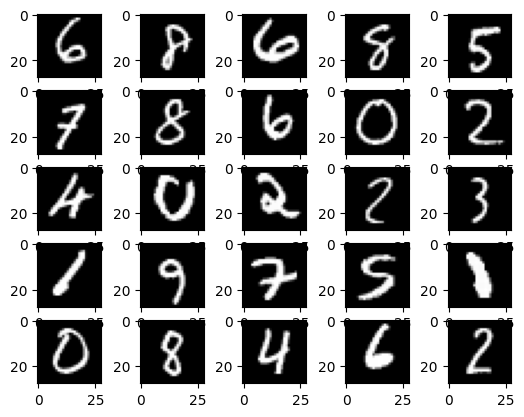

Predicted           Targets
6 8 6 8 5           6 8 6 8 5 
7 8 6 0 2           7 8 6 0 2 
4 0 2 2 3           4 0 2 2 3 
1 9 7 5 8           1 9 7 5 1 
0 8 4 6 2           0 8 4 6 2 


In [6]:
examples = iter(test_loader)
for batch_no in range(batch_size):
    example_data, example_targets = next(examples)

    a = 5      # Number of rows
    b = 5      # Number of images in each row [a*b <= 100]

    for i in range(a*b):
        plt.subplot(a,b,i+1)
        plt.imshow(example_data[i][0], cmap='gray')

    plt.show()    

    example_data = example_data.to(device)
    example_targets = example_targets.to(device)
    outputs2 = model(example_data)
    _2, predicted2 = torch.max(outputs2.data, 1)

    print("Predicted"+b*'  ',"Targets")
    for i in range(a):
        for j in range(b):
            print(predicted2[b*i+j].item(),end=' ')
        print(10*' ',end='')
        for j in range(b):
            print(example_targets[b*i+j].item(),end=' ')
        print()